In [1]:
import glob
import Colors
from scipy.cluster.hierarchy import dendrogram, linkage
from neupy import algorithms
from scipy.stats.stats import pearsonr   
from scipy.interpolate import interp1d
import itertools as it
import statsmodels.stats.multitest as multi
import venn

In [2]:
from matplotlib.patches import Rectangle, Circle

In [3]:
np.random.seed(174612)

# read data

In [4]:
glob.glob('../*coutt*')

['../mG01_E08_5dAA_lngf.coutt.tsv',
 '../mG01_E08_5dAA_lngf.normfilt.coutt.tsv',
 '../mG01_E08_5dAA_lngf.zscore.coutt.tsv',
 '../mG02_F08_5dAA_lngf.coutt.tsv',
 '../mG02_F08_5dAA_lngf.normfilt.coutt.tsv',
 '../mG02_F08_5dAA_lngf.zscore.coutt.tsv',
 '../mG03_B10_5dAA_lngf.coutt.tsv',
 '../mG03_B10_5dAA_lngf.normfilt.coutt.tsv',
 '../mG03_B10_5dAA_lngf.zscore.coutt.tsv',
 '../mG_E08F08B10_5dAA.zscore.coutt.tsv']

In [5]:
files5d = ['../mG01_E08_5dAA_lngf.coutt.tsv','../mG02_F08_5dAA_lngf.coutt.tsv','../mG03_B10_5dAA_lngf.coutt.tsv']

In [6]:
dfs5d = [read_csv(f, sep = '\t', index_col=0).astype(int) for f in files5d]

In [7]:
g_annotate=['Cdx2','Rspo3','Sox1','Sox2','Wnt3a','Fgf8','Uncx','Aldh1a2','Nkx1-2','Cyp26a1', 'Foxb1', 'Ets2',
            'Hes3','Pax6','Irx3','Irx5','Sox21','Dbx1','Dll1','Meox1','Tcf15','Pax3','Ptn','Klf3','Spon1', 'Rab3il1',
          'Mesp2','Ripply2','Dppa5a','Meox1','Tbx6','T', 'Hand1', 'Hand2', 'Gata6', 'Mef2c']

# common genes

In [8]:
def findUbiGenes(dfs):
    genes = []
    for df in dfs:
        genes += list(df.loc[df.sum(axis=1)>0].index)
    cnt = Counter(genes)
    gs = [g for g in cnt if cnt[g]==len(dfs)]
    print(len(cnt), len(gs))
    return gs

In [9]:
g5 = findUbiGenes(dfs5d)
dfs5d = [df.loc[g5] for df in dfs5d]

39533 26287


# number of reads and genes per section

### 5dAA

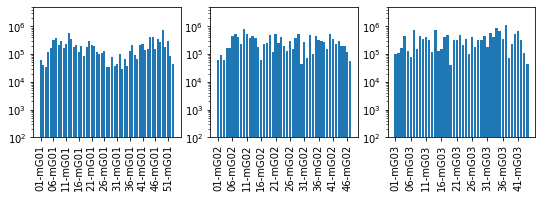

In [10]:
plt.figure(figsize=(3*len(dfs5d),2.4))
for i, df in enumerate(dfs5d):
    plt.subplot(1,len(dfs5d),i+1)
    cnt = df.sum()
    plt.bar(cnt.keys(), cnt)
    plt.yscale('log')
    plt.ylim(1e2,5e6)
    plt.xticks(range(len(df.columns))[::5], df.columns[::5], rotation = 90)
plt.show()

# normalize and prepare data, the same way as always

In [11]:
def removeGenes(df):
    genes = ['ERCC','chrM', 'Kcnq1ot1', 'Mir5109', 'Lars2','Malat1', 'Rn45s', 'Rpl', 'Rps','__MT']
    exclude = [idx for idx in df.index for g in genes if g in idx]
    return df.loc[[idx for idx in df.index if idx not in exclude]]

def removeGmGenes(df):
    g = []
    for idx in df.index:
        if 'Gm' in idx:
            gid = idx.rsplit('Gm')[1].rsplit('__')[0]
            if sum([n in [str(r) for r in range(10)] for n in gid]) == len(gid):
                g.append(idx)
    return df.loc[[idx for idx in df.index if idx not in g]]

In [12]:
def filter_norm_dfs(dfs):
#    fdfs = [removeGmGenes(removeGenes(df)) for df in dfs]
    fdfs = [removeGenes(df) for df in dfs]
    fdfs = [df.loc[df.index[df.sum(axis=1)>0]] for df in fdfs]
    nfdfs = [df.sum().mean()*df/df.sum() for df in fdfs]
    return fdfs, nfdfs

fdfs5d, nfdfs5d = filter_norm_dfs(dfs5d)


In [13]:
def zscore(df):
    df = df.loc[df.index[df.sum(axis=1)>0]]
    zdf = df.T
    zdf = (zdf-zdf.mean())/zdf.std()
    zdf = zdf.T
    return zdf

def scalezscore(zdf):
    df  = ((zdf.T>=0)*zdf.T/zdf.max(axis=1) + (zdf.T<0)*zdf.T/abs(zdf.min(axis=1))).T
    return df

In [14]:
znfdfs5d = [zscore(df) for df in nfdfs5d]

sznfdfs5d = [scalezscore(df) for df in znfdfs5d]

In [15]:
def mergeDfs(dfs):
    mdf = dfs[0]
    for i in range(1, len(dfs)):
        mdf = mdf.merge(dfs[i], how = 'outer', left_index = True, right_index = True)
    mdf = mdf.fillna(0)
    mdf = mdf.loc[mdf.sum(axis=1).sort_values(ascending=False).index]
    return mdf

mznfdfs5d = mergeDfs(znfdfs5d)
mznfdfs5d.to_csv('../mG_E08F08B10_5dAA.zscore.coutt.tsv', sep = '\t')

In [16]:
nfdfs5d[0].to_csv('../mG01_E08_5dAA_lngf.normfilt.coutt.tsv', sep = '\t')
nfdfs5d[1].to_csv('../mG02_F08_5dAA_lngf.normfilt.coutt.tsv', sep = '\t')
nfdfs5d[2].to_csv('../mG03_B10_5dAA_lngf.normfilt.coutt.tsv', sep = '\t')

In [17]:
znfdfs5d[0].to_csv('../mG01_E08_5dAA_lngf.zscore.coutt.tsv', sep = '\t')
znfdfs5d[1].to_csv('../mG02_F08_5dAA_lngf.zscore.coutt.tsv', sep = '\t')
znfdfs5d[2].to_csv('../mG03_B10_5dAA_lngf.zscore.coutt.tsv', sep = '\t')

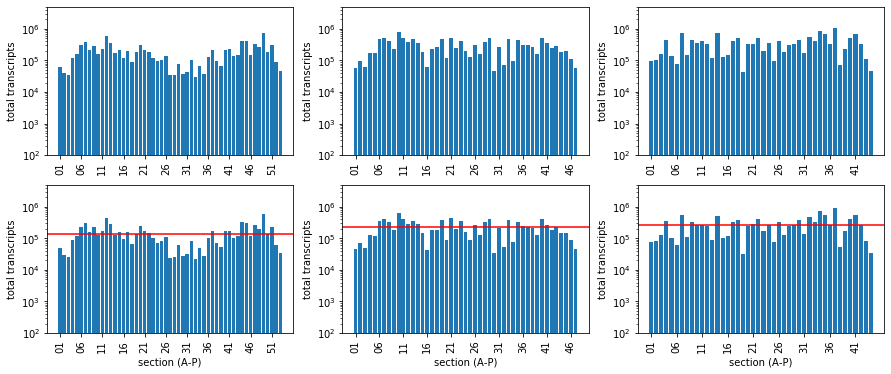

In [18]:
plt.figure(figsize=(15,6))
for i, df in enumerate(dfs5d):
    plt.subplot(2,len(dfs5d),i+1)
    cnt = df.sum()
    plt.bar(cnt.keys(), cnt)
    plt.yscale('log')
    plt.ylim(1e2,5e6)
    plt.ylabel('total transcripts')
    plt.xticks(range(len(df.columns))[::5], [c.rsplit('-')[0] for c in df.columns[::5]], rotation = 90)
for i, df in enumerate(fdfs5d):
    plt.subplot(2,len(dfs5d),i+1+3)
    cnt = df.sum()
    plt.bar(cnt.keys(), cnt)
    plt.axhline(cnt.mean(), c = 'r')
    plt.yscale('log')
    plt.ylim(1e2,5e6)
    plt.xlabel('section (A-P)')
    plt.ylabel('total transcripts')
    plt.xticks(range(len(df.columns))[::5], [c.rsplit('-')[0] for c in df.columns[::5]], rotation = 90)
plt.savefig('../results/lfngMouseGastruloids/mG010203_filtered_transcriptcount.pdf', bbox_inches = 'tight')
plt.show()

# Identify reproducible genes in each timepoint

## Background model

In [19]:
def simulationCorrelations(n1, n2, N = 5000):
    x1 = np.linspace(0,1,n1)
    x2 = np.linspace(0,1,n2)
    ps = [0 for i in range(N)]
    for i in range(N):
        d1 = np.random.rand(n1)
        d2 = np.random.rand(n2)

        id2 = interp1d(x2, d2, kind='quadratic')
        ps[i] = pearsonr(d1, id2(x1))[0]
    psdf = pd.DataFrame({'corr': sorted(ps), 'cum': np.linspace(0,1, N)})
    psdf['pval'] = 1.-psdf['cum']
    return psdf

## Correlation between genes

In [20]:
def geneCorrelation(df1, df2):
    x1 = 1.0*np.arange(len(df1.columns))/(len(df1.columns)-1)
    x2 = 1.0*np.arange(len(df2.columns))/(len(df2.columns)-1)
    cnt = Counter(list(df1.index) + list(df2.index))
    genes = [g for g in cnt if cnt[g] == 2]
    
    cdf = pd.Series(0, index = genes)
    for g in genes:
        idf2 = interp1d(x2, df2.loc[g].values, kind='quadratic')
        cdf.loc[g] = pearsonr(df1.loc[g], idf2(x1))[0]
    return cdf

In [21]:
def assignPval2corr(cdf, pdf, corrcolname = 'corr'):
    cdf2 = pd.DataFrame(cdf, columns = [corrcolname])
    cdf2['pv'] = 0
    for g in cdf.index:
        pv = cdf.loc[g]
        if (pdf['corr'] >= pv).sum() > 0:
            p0 = pdf[pdf['corr'] >= pv].iloc[0]['pval']
        else:
            p0 = 0.
        if (pdf['corr'] <pv).sum() > 0:
            p1 = pdf[pdf['corr'] < pv].iloc[-1]['pval']
        else:
            p1 = 1.
        cdf2.loc[g,'pv'] = 0.5*(p0+p1)
    cdf2['adj-pv'] = multi.fdrcorrection(cdf2['pv'],  method='indep')[1]
    return cdf2      

In [22]:
def mergeGeneLists(gene_list):
    for x in gene_list:
        gene_list[x].columns = [str(c) + '_' + str(x) for c in gene_list[x].columns]
    ks = list(gene_list.keys())
    mdf = gene_list[ks[0]]
    for i in range(1,len(ks)):
        mdf = mdf.merge(gene_list[ks[i]], how = 'inner', left_index = True, right_index = True)
    return mdf

In [23]:
pv_sim_5d = {}
corrGenes_5d = {}
for x, (i1, i2) in enumerate(it.combinations(range(len(znfdfs5d)), 2)):
    pv_sim_5d[(i1, i2)] = simulationCorrelations(n1 = len(znfdfs5d[i1].columns), n2 = len(znfdfs5d[i2].columns))
    corrGenes_5d[(i1, i2)] = geneCorrelation(znfdfs5d[i1], znfdfs5d[i2])
    corrGenes_5d[(i1, i2)] = assignPval2corr(corrGenes_5d[(i1, i2)], pv_sim_5d[(i1,i2)])
mdf5d = mergeGeneLists(corrGenes_5d)

In [24]:
mdf5d.head(10)

,"corr_(0, 1)","pv_(0, 1)","adj-pv_(0, 1)","corr_(0, 2)","pv_(0, 2)","adj-pv_(0, 2)","corr_(1, 2)","pv_(1, 2)","adj-pv_(1, 2)"
ENSMUSG00000000001_Gnai3__protein_coding__3,-0.052702,0.648430,0.849729,-0.026991,0.582617,0.878416,-0.065006,0.671834,0.885385
ENSMUSG00000000028_Cdc45__protein_coding__16,-0.149606,0.857471,0.900678,0.233418,0.042509,0.309357,-0.092482,0.739648,0.885385
ENSMUSG00000000031_H19__lincRNA__7,0.563323,0.000000,0.000000,0.528238,0.000000,0.000000,0.553930,0.000000,0.000000
ENSMUSG00000000037_Scml2__protein_coding__X,-0.174997,0.892879,0.922340,0.080947,0.279956,0.878416,0.133182,0.181936,0.692565
ENSMUSG00000000056_Narf__protein_coding__11,-0.196799,0.918484,0.939695,0.150490,0.131726,0.599934,0.124855,0.197139,0.721206
ENSMUSG00000000058_Cav2__protein_coding__6,-0.072480,0.698440,0.849729,-0.042576,0.630226,0.878416,0.287000,0.028306,0.233870
ENSMUSG00000000078_Klf6__protein_coding__13,0.110947,0.216743,0.696881,-0.069237,0.694839,0.878416,-0.003107,0.512603,0.885385
ENSMUSG00000000085_Scmh1__protein_coding__4,-0.178899,0.898680,0.926258,0.048302,0.371774,0.878416,0.264070,0.038908,0.285486
ENSMUSG00000000088_Cox5a__protein_coding__9,0.384201,0.002300,0.030439,0.263034,0.025305,0.219838,0.205314,0.087918,0.474652
ENSMUSG00000000093_Tbx2__protein_coding__11,0.062475,0.331166,0.849729,0.244027,0.034507,0.269339,0.182580,0.108122,0.524622


In [25]:
mdf5d.to_csv('../results/lfngMouseGastruloids/geneCorrelations_5dAA.tsv', sep = '\t')

# Gene selection for each timepoint

## 5dAA

In [26]:
pvcols = [c for c in mdf5d.columns if 'pv_('==c[:4]]

In [27]:
# pvthdf = pd.Series()
# nth = 3
# for pvth in np.linspace(0,1,20):
#     ng = len(mdf5d.index[mdf5d.apply(lambda x: sum(x[pvcols]<pvth), axis = 1) >= nth])
#     pvthdf.loc[pvth] = ng
#     print(pvth, ng)

In [28]:
# plt.scatter(pvthdf.index, pvthdf)
# plt.xlabel('pv threshold')
# plt.ylabel('surviving genes')
# plt.savefig('../results/lfngMouseGastruloids/pvalth_reprGenes.pdf', bbox_inches = 'tight')
# plt.show()

In [29]:
pvth = 0.1; nth = 3
gl_5d = mdf5d.index[mdf5d.apply(lambda x: sum(x[pvcols]<pvth), axis = 1) >= nth]

In [30]:
len(gl_5d), len(mdf5d)

(1456, 25828)

/Users/anna/anaconda/envs/py36/lib/python3.6/site-packages/venn/_backwards_compatibility.py:17: UserWarning: `get_labels()` is retained for backwards compatibility; use `generate_petal_labels()` or the higher level `venn()` instead
  "use `generate_petal_labels()` or the higher level `venn()` instead"
/Users/anna/anaconda/envs/py36/lib/python3.6/site-packages/venn/_backwards_compatibility.py:32: UserWarning: `venn3()` is retained for backwards compatibility; use `venn()` instead
  "use `venn()` instead"


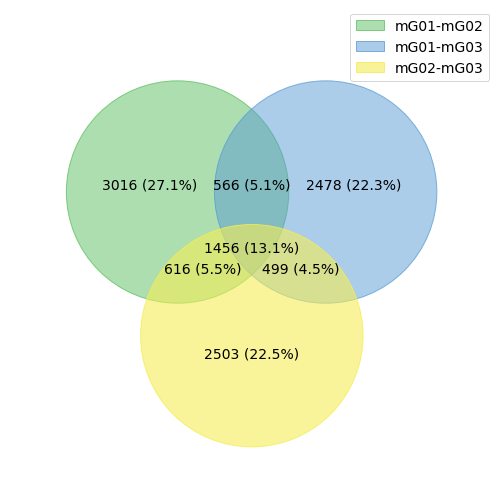

In [31]:
labels = venn.get_labels([set(mdf5d[mdf5d[pvc]<pvth].index) for pvc in pvcols], 
                         fill=['number','percent'])

for k in labels:
    if labels[k][0:1]=='0': 
        labels[k] = ''
        
fig, ax = venn.venn3(labels, names=['mG01-mG02', 'mG01-mG03','mG02-mG03'])

plt.savefig('../results/lfngMouseGastruloids/venn_genePval01.pdf', bbox_inches = 'tight')
plt.show()

# check reproducibility

In [32]:
def SOMclustering(df, gridheight = 10, gridwidth = 10, seed = 54321):
    np.random.seed = seed
    GRID_HEIGHT = gridheight
    GRID_WIDTH = gridwidth
    somfun = algorithms.SOFM(
            n_inputs=len(df.columns),
            features_grid=(GRID_HEIGHT, GRID_WIDTH),
            learning_radius=4,
            reduce_radius_after=50,
            step=0.5,
            std=1,
            shuffle_data=True,
            verbose=False)
    somfun.train(np.array(df), epochs = 300)
    clustersr = somfun.predict(np.array(df)).argmax(axis=1)
    cl_genelist_df = pd.Series(clustersr, index = df.index)
    return cl_genelist_df

def hierarchicalClustering(df, cth = 100, plot = False, method = 'ward', metric = 'euclidean', nolabels = 'True'):
    Z = linkage(df, method=method, metric = metric)
    dg = dendrogram(Z, no_labels=nolabels, color_threshold=cth, no_plot = np.invert(plot))
    plt.show()
    return Z, dg

def getClusterByColor(dg, labels):
    kk = []
    ii = 0
    cluster = 0
    color = dg['color_list'][0]
    clusters = {cluster: []}
    for i in range(len(dg['icoord'])):
        v = dg['icoord'][i]
        for j in [0,2]:
            vj = int(round((v[j]-5.)/10))
            if (v[j]-5.)/10 == vj and vj not in kk:
                kk.append(vj)
                if dg['color_list'][i] == color:
                    clusters[cluster].append(labels[dg['leaves'][vj]])
                else:
                    color = dg['color_list'][i]
                    cluster += 1
                    clusters[cluster] = [labels[dg['leaves'][vj]]]
    return clusters

def comboCluster(df, genes, gridheight = 10, gridwidth = 10, cth = 100, plot = True, method = 'ward', metric = 'euclidean', seed = 12345, nolabels = 'True'):
    somcl = SOMclustering(df.loc[genes], gridheight = gridheight, gridwidth = gridwidth, seed = seed)
    mdf_som = pd.DataFrame({i: df.loc[somcl[somcl==i].index].mean() for i in set(somcl) })
    Z, dg = hierarchicalClustering(mdf_som.T, cth = cth, plot = plot, method = method, metric = metric, nolabels = nolabels)
    if plot:
        plt.show()
    ghcl = getClusterByColor(dg, list(mdf_som.columns))
    cl_df = pd.DataFrame(somcl, columns = ['som'])
    cl_df['hcl'] = [k for s in cl_df['som'] for k in ghcl.keys() if s in ghcl[k]]
    return cl_df

In [33]:
5*np.sqrt(len(gl_5d))

190.78784028338913

In [34]:
def mergeDfs(dfs):
    mdf = dfs[0]
    for i in range(1, len(dfs)):
        mdf = mdf.merge(dfs[i], how = 'outer', left_index = True, right_index = True)
    mdf = mdf.fillna(0)
    mdf = mdf.loc[mdf.sum(axis=1).sort_values(ascending=False).index]
    return mdf

In [35]:
mznfdfs5d = mergeDfs(znfdfs5d)

## 5dAA 

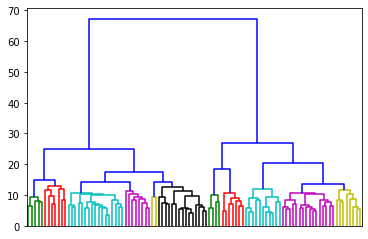

In [36]:
somhcl_5d_df = comboCluster(mznfdfs5d, gl_5d, cth=13)

In [37]:
somhcl_5d_df.sort_values(by=['hcl','som']).to_csv('../results/lfngMouseGastruloids/heatmap_5d_reprGenes.tsv', sep = '\t')
somhcl_5d_df.sort_values(by=['hcl','som']).to_csv('../results/GOterms_gld/heatmap_5d_reprGenes.tsv', sep = '\t')


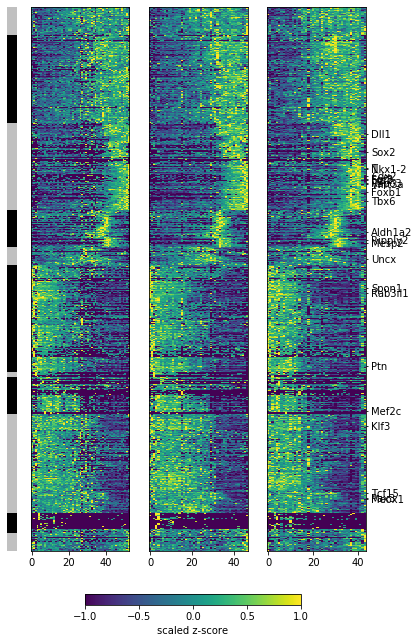

In [38]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize = (6,10))

gene_order = somhcl_5d_df.sort_values(by=['hcl','som']).index

im = ['' for i in range(len(ax))]
for i, df in enumerate(sznfdfs5d):
    im[i] = ax[i].imshow(df.loc[gene_order][::-1], aspect = 'auto')
    ax[i].set_yticks([])
ax[-1].tick_params('y', length = 2, labelleft=False, labelright=True, left = False, right=True)
ax[-1].set_yticks([i for i, g in enumerate(gene_order[::-1]) if g.rsplit('_')[1] in g_annotate])
ax[-1].set_yticklabels([g.rsplit('_')[1] for g in gene_order[::-1] if g.rsplit('_')[1] in g_annotate])

cbaxes = fig.add_axes([0.25, 0.05,0.5, 0.015])
fig.colorbar(im[-1], label = 'scaled z-score', orientation = 'horizontal', cax = cbaxes)

dx = 0.1*len(sznfdfs5d[0].columns)
x0 = -2.5*dx
y0 = len(somhcl_5d_df)-0.5
for cl in set(somhcl_5d_df['hcl']):
    c = 'silver' if np.mod(cl,2)==0 else 'k'
    n = (somhcl_5d_df['hcl']==cl).sum()
    rect = Rectangle((x0,y0-n), dx, n, lw = 2, edgecolor = None, facecolor = c, clip_on=False)
    ax[0].add_patch(rect)
    y0 -= n

plt.savefig('../results/lfngMouseGastruloids/heatmap_5d_reprGenes.pdf', bbox_inches = 'tight')
plt.savefig('../results/GOterms_gld/heatmap_5d_reprGenes.pdf', bbox_inches = 'tight')

plt.show()

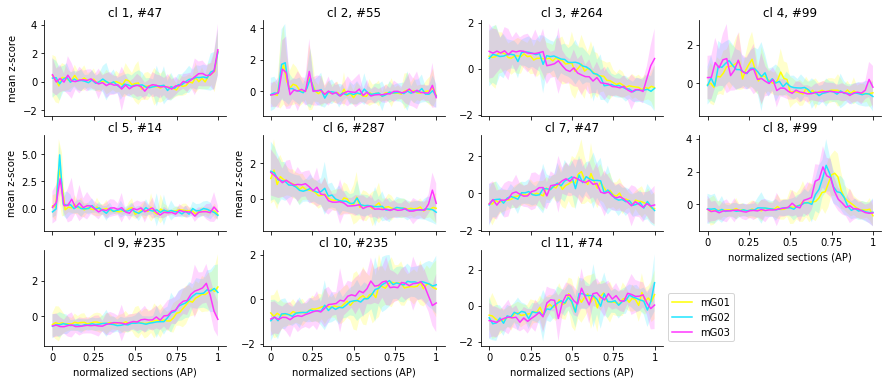

In [54]:
fig = plt.figure(figsize=(15,6))

for cl in set(somhcl_5d_df['hcl']):
    ax = fig.add_subplot(3,4,cl+1)
    genes = somhcl_5d_df[somhcl_5d_df['hcl']==cl].index
    for i, df in enumerate(znfdfs5d):
        xra = np.linspace(0,1,len(df.columns))
        
        mu = df.loc[genes].mean()
        mup = mu + df.loc[genes].std()
        mum = mu - df.loc[genes].std()
       
        ax.plot(xra, mu, c = Colors.colors[i])
        ax.fill_between(xra, mup, mum, facecolor=Colors.colors[i], interpolate=True, alpha = 0.2)
        
    ax.set_title('cl '+str(cl+1)+', #'+str(len(genes)), pad = -100)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([0,0.25,0.50,0.75,1]); ax.set_xticklabels([])

    if cl+1 in [1,5,6]:
        ax.set_ylabel('mean z-score')
    if cl+1 >= 8:
        plt.xlabel('normalized sections (AP)')
        ax.set_xticklabels([0,0.25,0.50,0.75,1])
        
plt.legend(['mG01', 'mG02', 'mG03'], loc = 2, bbox_to_anchor = (1,0.6))
plt.savefig('../results/lfngMouseGastruloids/lineplots_5d_reprGenes.pdf', bbox_inches = 'tight')
plt.show()

In [40]:
# prepare population list
pd.DataFrame([idx.rsplit('_')[1] for idx in somhcl_5d_df.index]).to_csv('../results/GOterms_gld/population.txt', sep = '\t', index = None, header = None)


In [41]:
# prepare the hclusters
for hcl in set(somhcl_5d_df['hcl']):
    gs = [idx.rsplit('_')[1] for idx in somhcl_5d_df[somhcl_5d_df['hcl']==hcl].index]
    pd.DataFrame(gs).to_csv('../results/GOterms_gld/hcl_' + str(hcl).zfill(2) + '.txt', sep = '\t', index = None, header = None)

In [42]:
183/2

91.5

In [55]:
set(somhcl_5d_df['hcl']), somhcl_5d_df.shape

({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}, (1456, 2))

In [44]:
# for cl in set(somhcl_5d_df['hcl']):
#     print(str(cl) + ' & ' + ', '.join(sorted([g.rsplit('_')[1] for g in somhcl_5d_df[somhcl_5d_df['hcl']==cl].index])) + '\\\\')

# Average gastruloid

In [45]:
def averageGastruloid(mzdf,n):
    mdf = mzdf.T
    glds = set([c.rsplit('-')[-1] for c in mdf.index])
    mdf['x'] = 0
    for gld in glds:
        idxs = [c for c in mdf.index if gld == c.rsplit('-')[-1]]
        xra = np.linspace(0,1,len(idxs))
        for idx, x in zip(idxs, xra):
            mdf.loc[idx,'x'] = x
    mdf = mdf.sort_values(by = 'x', ascending = True)
    xdf = pd.DataFrame(columns = mdf.columns, index = range(n))
    xra = np.linspace(0,1,n+1)
    for i in range(len(xra)-1):
        idxs = [c for c in mdf.index if xra[i]<mdf.loc[c,'x']<=xra[i+1]]
        xdf.loc[i] = mdf.loc[idxs].mean()
    del xdf['x']
    return xdf.T

In [46]:
xzdf = averageGastruloid(mznfdfs5d, 44).astype(float)

In [47]:
xzdf.to_csv('../mGav_Lfng_zscores.tsv', sep ='\t')

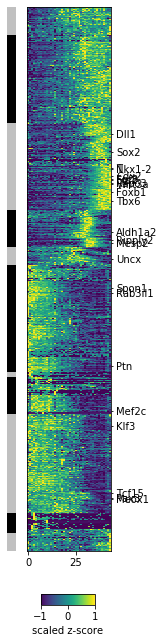

In [48]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (1.5,10))

gene_order = somhcl_5d_df.sort_values(by=['hcl','som']).index

df = scalezscore(xzdf)
im = ax.imshow(df.loc[gene_order][::-1], aspect = 'auto')
ax.set_yticks([])
ax.tick_params('y', length = 2, labelleft=False, labelright=True, left = False, right=True)
ax.set_yticks([i for i, g in enumerate(gene_order[::-1]) if g.rsplit('_')[1] in g_annotate])
ax.set_yticklabels([g.rsplit('_')[1] for g in gene_order[::-1] if g.rsplit('_')[1] in g_annotate])

cbaxes = fig.add_axes([0.25, 0.05,0.5, 0.015])
fig.colorbar(im, label = 'scaled z-score', orientation = 'horizontal', cax = cbaxes)

dx = 0.1*len(df.columns)
x0 = -2.5*dx
y0 = len(somhcl_5d_df)-0.5
for cl in set(somhcl_5d_df['hcl']):
    c = 'silver' if np.mod(cl,2)==0 else 'k'
    n = (somhcl_5d_df['hcl']==cl).sum()
    rect = Rectangle((x0,y0-n), dx, n, lw = 2, edgecolor = None, facecolor = c, clip_on=False)
    ax.add_patch(rect)
    y0 -= n

plt.savefig('../results/lfngMouseGastruloids/heatmap_5d_reprGenes_avGld.pdf', bbox_inches = 'tight')

plt.show()